This notebook contains the code of our implementation of the **Injecting and removing malignant features in mammography with CycleGAN: Investigation of an automated adversarial attack using neural networks**, Anton S. Becker, Lukas Jendele, Ondrej Skopek, Nicole Berger, Soleen Ghafoor, Magda Marcon, Ender Konukoglu.</br>
</br>
For our experiment of using CycleGANs, we used the **official implementation**: https://github.com/BreastGAN </br>
</br>
We used only **IN-Breast** (refer to http://medicalresearch.inescporto.pt/breastresearch/index.php/Get_INbreast_Database). We could not get the BCDR dataset.</br>
</br>
**We want to stress that the code used for the CycleGANs have been adapted from https://github.com/BreastGAN/experiment1**





> 
> 
>
> 
>
>
>
>
>
>
>











#Import + mounting the Drive

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
!pip install pydicom
import pydicom
import html
import os
from tqdm.notebook import tqdm
import random

from google.colab import drive

drive.mount('/content/gdrive')

     |████████████████████████████████| 1.9MB 14.3MB/s 
Mounted at /content/gdrive


#Cloning the Git repo + downloading the data

In [ ]:
!git clone https://github.com/BreastGAN/experiment1

Cloning into 'experiment1'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), done.


#Metadata

In [ ]:
dict_labels = {0: 'Needs additional imaging evaluation and/or prior mammograms for comparison',
               1: 'Negative',
               2: 'Benign finding(s)',
               3: 'Probably benign finding(s). Short-interval follow-up is suggested.',
               4: 'Suspicious anomaly. Biopsy should be considered.',
               5: 'Highly suggestive of malignancy. Appropriate action should be taken.',
               6: 'Biopsy proven malignancy'
               }

In [ ]:
df_meta = pd.read_csv('INbreast/INbreast.csv',sep=';') 
df_meta

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads
0,removed,removed,R,CC,201001,22678622,4,1
1,removed,removed,L,CC,201001,22678646,4,3
2,removed,removed,R,MLO,201001,22678670,4,1
3,removed,removed,L,MLO,201001,22678694,4,3
4,removed,removed,R,CC,201001,22614074,2,5
...,...,...,...,...,...,...,...,...
405,removed,removed,L,MLO,201001,22613848,2,1
406,removed,removed,L,MLO,200802,24055725,4,2
407,removed,removed,R,MLO,200802,24055752,4,2
408,removed,removed,L,CC,200802,24055779,4,2


In [ ]:
df_xls = pd.read_excel('INbreast/INbreast.xls')
df_xls

,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads,Mass,Micros,Distortion,Asymmetry,Findings Notes (in Portuguese),Other Notes,Lesion Annotation Status,Pectoral Muscle Annotation,Other Annotations
0,R,CC,200902.0,20586908.0,2,2,X,X,NaN,NaN,nodulo mama direita + micros,NaN,NaN,NaN,NaN
1,L,CC,200902.0,20586934.0,2,5,X,X,NaN,NaN,nodulo esquerda + micros,NaN,Spiculated Region,NaN,11mm a parte mais densa
2,R,MLO,200902.0,20586960.0,2,2,X,X,NaN,NaN,2nodulos mama direita + micros,NaN,NaN,NaN,NaN
3,L,MLO,200902.0,20586986.0,2,5,X,X,NaN,NaN,nodulo mama esquerda + micros,NaN,Spiculated Region,NaN,NaN
4,R,CC,200902.0,20587054.0,2,4c,NaN,X,NaN,NaN,micros;Cluster,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,L,MLO,201001.0,53587690.0,1,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
408,R,MLO,201001.0,53587717.0,1,2,NaN,X,NaN,NaN,calcificações - follow up,NaN,NaN,NaN,NaN
409,L,CC,201001.0,53587744.0,1,1,NaN,NaN,NaN,NaN,normal,NaN,No annotation (Normal),NaN,NaN
410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Labelling the data

##Labelling wrt. the view & Bi-RADS

In [ ]:
df_benign_CC = df_meta[~df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6']) & df_meta.View.isin(['CC'])]
df_malignant_CC = df_meta[df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6'])& df_meta.View.isin(['CC'])]

df_benign_MLO = df_meta[~df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6']) & df_meta.View.isin(['MLO'])]
df_malignant_MLO = df_meta[df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6'])& df_meta.View.isin(['MLO'])]

,Patient ID,Patient age,Laterality,View,Acquisition date,File Name,ACR,Bi-Rads
2,removed,removed,R,MLO,201001,22678670,4,1
7,removed,removed,L,MLO,201001,22614150,2,2
8,removed,removed,L,MLO,201001,50997434,3,2
19,removed,removed,L,MLO,201001,22580270,2,1
22,removed,removed,R,MLO,201001,50998086,3,2
...,...,...,...,...,...,...,...,...
397,removed,removed,L,MLO,201001,22678518,1,2
400,removed,removed,R,MLO,201001,22580068,2,2
405,removed,removed,L,MLO,201001,22613848,2,1
406,removed,removed,L,MLO,200802,24055725,4,2


##Labelling wrt. the "Mass"feature

In [ ]:
df_benign_mass = df_xls[~ df_xls['Mass '].isin(['X'])]
df_malignant_mass = df_xls[df_xls['Mass '].isin(['X'])]

id_benign_mass = df_benign_mass['File Name'].to_list()
id_malignant_mass = df_malignant_mass['File Name'].to_list()

list_benign = [i for i in os.listdir('INbreast/AllDICOMs/') if i[-3:]=='dcm' and int(i.split('_')[0]) in id_benign_mass ]
list_malignant = [i for i in os.listdir('INbreast/AllDICOMs/') if i[-3:]=='dcm' and int(i.split('_')[0]) in id_malignant_mass ]

##Labelling wrt. the Bi-Rads feature

In [ ]:
df_benign = df_meta[~df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6'])]
df_malignant = df_meta[df_meta['Bi-Rads'].isin(['3','4a','4b','4c','5','6'])]

id_benign = df_benign['File Name'].to_list()
id_malignant = df_malignant['File Name'].to_list()

list_benign = [i for i in os.listdir('INbreast/AllDICOMs/') if i[-3:]=='dcm' and int(i.split('_')[0]) in id_benign ]
list_malignant = [i for i in os.listdir('INbreast/AllDICOMs/') if i[-3:]=='dcm' and int(i.split('_')[0]) in id_malignant ]

#VISUALIZATION

##BENIGN

In [ ]:
plt.subplots(3, 3, figsize=(10, 8))
rand_list = [list_benign[i] for i in np.random.randint(len(list_benign), size=9)]
for i,path in enumerate(rand_list):
    file = os.path.join('INbreast/AllDICOMs/',path)
    ds = pydicom.dcmread(file)
    arr = ds.pixel_array
    print(arr.shape)
    plt.subplot(3, 3, i + 1)
    plt.imshow(arr)
    plt.axis("off")
plt.show()

##MALIGNANT

In [ ]:
plt.subplots(3, 3, figsize=(18, 8))
rand_list = [list_malignant[i] for i in np.random.randint(len(list_malignant), size=9)]
for i,path in enumerate(rand_list):
    file = os.path.join('INbreast/AllDICOMs/',path)
    ds = pydicom.dcmread(file)
    arr = ds.pixel_array
    plt.subplot(3, 3, i + 1)
    plt.imshow(arr)
    plt.axis("off")
plt.show()

#VIZ + SEGMENTATION

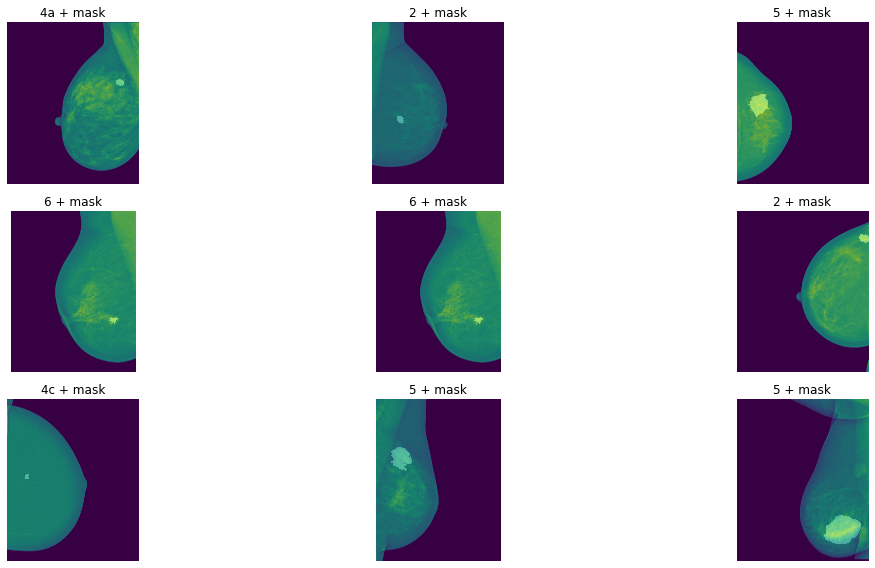

In [ ]:
mask_list = [i for i in os.listdir('INbreast/extras/MassSegmentationMasks/') if i[-3:]=='png']

plt.subplots(3, 3, figsize=(18, 8))
for i,k in enumerate(np.random.randint(len(list_malignant), size=9)):
    file = os.path.join('INbreast/AllDICOMs/',list_malignant[k])
    id = list_malignant[k].split('_')[0]
    num_label = df_meta['Bi-Rads'][df_meta['File Name'] == int(id)].item()
    mask_path = os.path.join('INbreast/extras/MassSegmentationMasks/',id+'_mask.png')
    ds = pydicom.dcmread(file)
    arr = ds.pixel_array
    plt.subplot(3, 3, i + 1)
    #plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr)
    if id+'_mask.png' in mask_list:
      mask = Image.open(mask_path)
      plt.imshow(mask, 'jet', interpolation='none', alpha=0.2)
      num_label = num_label + ' + mask'
    plt.title(num_label)
    plt.axis("off")
plt.tight_layout()
plt.show()

#Data preprocessing

In [ ]:
import numpy as np
from PIL import Image
import pydicom
import skimage.transform

def to_numpy(img):
    width, height = img.size
    return np.reshape(img.getdata(), (height, width)).astype(np.float64)


def load_dicom(path):
    dcm = pydicom.dcmread(path)
    img = dcm.pixel_array
    return np.asarray(img).astype(np.float64)


def load_tif(path):
    return to_numpy(Image.open(path))


def load_image(path):
    if path.endswith('.dcm'):
        return load_dicom(path)
    elif path.endswith('.tif'):
        return load_tif(path)
    else:
        raise ValueError('Unknown file format for file {}'.format(path))


def standardize(img, img_meta):
    if img_meta.laterality == 'R':  # horizontal flip for right breasts
        img = np.flip(img, axis=1)  # TODO(#6): Might not be what we want
    # TODO(#6) what about MLO view?
    return img


def normalize_gaussian(img, mean=None, std=None):
    """
    Normalizes an image by the mean and dividing by std (Gaussian normalization).

    If mean or std is None, uses np.mean or np.std respectively.
    """
    if mean is None:
        mean = np.mean(img)
    if std is None:
        std = np.std(img)
    img = img - mean
    img = img / std  # Needed for comparable histograms!
    return img


def normalize(img, new_min=0, new_max=255):
    """
    Normalizes an image by linear transformation into the interval [new_min, new_max].
    """
    old_min = np.min(img)
    old_max = np.max(img)
    img = (img - old_min) * ((new_max - new_min) / (old_max - old_min)) + new_min
    return img


def downsample(img, size=256):
    scale = size / max(img.shape)
    img = skimage.transform.rescale(img, scale, mode='constant')
    img_new = np.zeros((size, size))
    img_new[:img.shape[0], :img.shape[1]] = img  # Fill in to full size x size # TODO(#6) Is this a good idea?
    return img_new

##Augmentation

In [ ]:
import imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap

SEED = 42

imgaug.seed(SEED)
aug = iaa.Sequential([
    iaa.Affine(rotate=(-4, 4)),
    iaa.Affine(scale={
        "x": (0.98, 1.13),
        "y": (0.98, 1.13)
    }),
    iaa.ContrastNormalization((0.08, 1.2), per_channel=False)
])


In [ ]:
benign_array = []
malignant_array = []

for f in tqdm(list_benign):
  path = os.path.join('INbreast/AllDICOMs/',f)
  img = load_dicom(path)
  if df_meta.Laterality[df_meta['File Name'] == int(f.split('_')[0])].item() == 'R':
    img = np.flip(img, axis=1)
  img = downsample(img)
  img = normalize_gaussian(img)
  img = normalize(img, new_min=-1, new_max=1)
  benign_array.append(img)
  img_aug = aug.augment_image(img)
  benign_array.append(img_aug)
benign_array = np.asarray(benign_array)

for f in tqdm(list_malignant):
  path = os.path.join('INbreast/AllDICOMs/',f)
  img = load_dicom(path)
  if df_meta.Laterality[df_meta['File Name'] == int(f.split('_')[0])].item() == 'R':
    img = np.flip(img, axis=1)
  img = downsample(img)
  img = normalize_gaussian(img)
  img = normalize(img, new_min=-1, new_max=1)
  malignant_array.append(img)
  img_aug = aug.augment_image(img)
  malignant_array.append(img_aug)
malignant_array = np.asarray(malignant_array)


#MODEL ARCHITECTURE

##UTILS

In [ ]:
def tile_images(images, num_x, num_y, h, w):
    res = tf.zeros((num_y * h, num_x * w))
    index = -1
    rows = []
    for i in range(0, num_y):
        row = []
        for j in range(0, num_x):
            index += 1
            row.append(tf.reshape(images[index], (h, w)))
        rows.append(tf.concat(row, 1))
    res = tf.concat(rows, 0)
    print("res shape:", res.shape)
    return tf.reshape(res, (1, num_y * h, num_x * w, 1))

def next_batch(arr, batch_size):
    num_batches = int(len(arr) / batch_size)
    for i in range(0, num_batches * batch_size, batch_size):
        yield arr[i:i + batch_size]
    yield arr[num_batches * batch_size:]


def shuffle(a, b):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    return a[permutation], b[permutation]

##BUILD MODEL

In [ ]:
BATCH_SIZE = 1
ngf = 32
ndf = 64


# Copied from Cycle-GAN implmentation
def instance_norm(x):
    with tf.variable_scope("instance_norm"):
        epsilon = 1e-5
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        scale = tf.get_variable(
            'scale', [x.get_shape()[-1]], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.02))
        offset = tf.get_variable('offset', [x.get_shape()[-1]], initializer=tf.constant_initializer(0.0))
        out = scale * tf.div(x - mean, tf.sqrt(var + epsilon)) + offset

        return out


def conv2d(x, filters=3, kernel=3, strides=1, padding='VALID', relu=0.2, norm=True, name='conv'):
    with tf.variable_scope(name):
        out_res = tf.layers.conv2d(
            x,
            filters=filters,
            kernel_size=kernel,
            strides=strides,
            padding=padding,
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        if norm:
            out_res = instance_norm(out_res)
        if relu > 0:
            out_res = tf.nn.leaky_relu(out_res, alpha=relu)
        elif relu == 0:
            out_res = tf.nn.relu(out_res)
        return out_res


def deconv2d(x, outshape, filters=64, kernel=7, strides=1, padding="VALID", name="deconv2d", norm=True, relu=0.2):
    with tf.variable_scope(name):

        conv = tf.layers.conv2d_transpose(
            x,
            filters=filters,
            kernel_size=kernel,
            strides=strides,
            padding=padding,
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))

        if norm:
            conv = instance_norm(conv)

        if relu == 0:
            conv = tf.nn.relu(conv, "relu")
        elif relu > 0:
            conv = tf.nn.leaky_relu(conv, alpha=relu)

        return conv


def build_resnet_block(x, dim, name="resnet", padding='REFLECT'):
    with tf.variable_scope(name):
        with tf.variable_scope("Conv1"):
            out_res = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], padding)
            out_res = conv2d(out_res, filters=dim, name="conv1")
        with tf.variable_scope("Conv2"):
            out_res = tf.pad(out_res, [[0, 0], [1, 1], [1, 1], [0, 0]], padding)
            out_res = conv2d(out_res, filters=dim, name="conv2", relu=-1)

        return tf.nn.relu(out_res + x)


def build_generator_resnet_9blocks(x, name="generator", skip=True):
    with tf.variable_scope(name):
        f = 7
        ks = 3
        padding = "CONSTANT"

        pad_input = tf.pad(x, [[0, 0], [ks, ks], [ks, ks], [0, 0]], padding)
        o_c1 = conv2d(pad_input, filters=ngf, kernel=f, name="conv1")
        o_c2 = conv2d(o_c1, filters=ngf * 2, kernel=ks, strides=2, padding="SAME", name="conv2")
        o_c3 = conv2d(o_c2, filters=ngf * 4, kernel=ks, strides=2, padding="SAME", name="conv3")

        o_r = build_resnet_block(o_c3, ngf * 4, "r1", padding)
        for i in range(2, 10):
            o_r = build_resnet_block(o_r, ngf * 4, name="r" + str(i), padding=padding)

        o_c4 = deconv2d(
            o_r, [BATCH_SIZE, 128, 128, ngf * 2], filters=ngf * 2, kernel=ks, strides=2, padding="SAME", name="dc4")
        o_c5 = deconv2d(
            o_c4, [BATCH_SIZE, 256, 256, ngf], filters=ngf, kernel=ks, strides=2, padding="SAME", name="dc5")
        o_c6 = conv2d(o_c5, filters=1, kernel=f, padding="SAME", name="c6", norm=False, relu=-1)

        if skip is True:
            out_gen = tf.nn.tanh(x + o_c6, "t1")
        else:
            out_gen = tf.nn.tanh(o_c6, "t1")

        return out_gen


def discriminator(x, name="discriminator"):
    with tf.variable_scope(name):
        f = 4

        padw = 2

        with tf.variable_scope('Conv1'):
            pad_input = tf.pad(x, [[0, 0], [padw, padw], [padw, padw], [0, 0]], "CONSTANT")
            o_c1 = conv2d(pad_input, filters=ndf, kernel=f, strides=2, name="c1", norm=False)

        with tf.variable_scope('Conv2'):
            pad_o_c1 = tf.pad(o_c1, [[0, 0], [padw, padw], [padw, padw], [0, 0]], "CONSTANT")
            o_c2 = conv2d(pad_o_c1, filters=ndf * 2, kernel=f, strides=2, name="c2")

        with tf.variable_scope('Conv3'):
            pad_o_c2 = tf.pad(o_c2, [[0, 0], [padw, padw], [padw, padw], [0, 0]], "CONSTANT")
            o_c3 = conv2d(pad_o_c2, filters=ndf * 4, kernel=f, strides=2, name="c3")

        with tf.variable_scope('Conv4'):
            pad_o_c3 = tf.pad(o_c3, [[0, 0], [padw, padw], [padw, padw], [0, 0]], "CONSTANT")
            o_c4 = conv2d(pad_o_c3, filters=ndf * 8, kernel=f, strides=1, name="c4")

        with tf.variable_scope('Conv5'):
            pad_o_c4 = tf.pad(o_c4, [[0, 0], [padw, padw], [padw, padw], [0, 0]], "CONSTANT")
            o_c5 = conv2d(pad_o_c4, filters=1, kernel=f, name="c5", norm=False, relu=-1)

        return o_c5


def patch_discriminator(x, name="discriminator"):
    with tf.variable_scope(name):
        f = 4

        patch_input = tf.random_crop(x, [1, 70, 70, 3])
        o_c1 = conv2d(patch_input, filters=ndf, kernel=f, strides=2, padding="SAME", name="c1", norm=False)
        o_c2 = conv2d(o_c1, filters=ndf * 2, kernel=f, strides=2, padding="SAME", name="c2")
        o_c3 = conv2d(o_c2, filters=ndf * 4, kernel=f, strides=2, padding="SAME", name="c3")
        o_c4 = conv2d(o_c3, filters=ndf * 8, kernel=f, strides=2, padding="SAME", name="c4")
        o_c5 = conv2d(o_c4, filters=1, kernel=f, padding="SAME", name="c5", norm=False, relu=-1)

        return o_c5

In [ ]:
def build_model(inputs, skip=True):
    images_a = inputs['images_a']
    images_b = inputs['images_b']

    fake_pool_a = inputs['fake_pool_a']
    fake_pool_b = inputs['fake_pool_b']

    with tf.variable_scope("Model") as scope:
        prob_real_a_is_real = discriminator(images_a, "d_A")
        prob_real_b_is_real = discriminator(images_b, "d_B")
        generator = build_generator_resnet_9blocks

        fake_images_b = generator(images_a, name="g_A", skip=skip)
        fake_images_a = generator(images_b, name="g_B", skip=skip)

        scope.reuse_variables()

        prob_fake_a_is_real = discriminator(fake_images_a, "d_A")
        prob_fake_b_is_real = discriminator(fake_images_b, "d_B")

        cycle_images_a = generator(fake_images_b, "g_B", skip=skip)
        cycle_images_b = generator(fake_images_a, "g_A", skip=skip)

        scope.reuse_variables()

        prob_fake_pool_a_is_real = discriminator(fake_pool_a, "d_A")
        prob_fake_pool_b_is_real = discriminator(fake_pool_b, "d_B")

    return {
        'prob_real_a_is_real': prob_real_a_is_real,
        'prob_real_b_is_real': prob_real_b_is_real,
        'prob_fake_a_is_real': prob_fake_a_is_real,
        'prob_fake_b_is_real': prob_fake_b_is_real,
        'prob_fake_pool_a_is_real': prob_fake_pool_a_is_real,
        'prob_fake_pool_b_is_real': prob_fake_pool_b_is_real,
        'cycle_images_a': cycle_images_a,
        'cycle_images_b': cycle_images_b,
        'fake_images_a': fake_images_a,
        'fake_images_b': fake_images_b,
    }

In [ ]:
# Shortcut for loss calculation.
def cycle_consistency_loss(real_images, generated_images):
    """L1-norm difference between the real and generated images."""
    return tf.reduce_mean(tf.abs(real_images - generated_images))


def lsgan_loss_generator(prob_fake_is_real):
    """Least-squares generator loss"""
    return tf.reduce_mean(tf.squared_difference(prob_fake_is_real, 1))


def lsgan_loss_discriminator(prob_real_is_real, prob_fake_is_real):
    """Least-squares discriminator losses."""
    return (tf.reduce_mean(tf.squared_difference(prob_real_is_real, 1)) + tf.reduce_mean(
        tf.squared_difference(prob_fake_is_real, 0))) * 0.5


def cross_entropy_loss(logits=None, labels=None):
    #return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return tf.reduce_mean(logits)

In [ ]:
FLAGS = {
          "data": {
              "in_file": "data_in/images_256x256.npz", # Input data file.
              "out_dir": "data_out" # Directory where to write event logs and checkpoint. Will create a $MODEL_RUN directory in it.
          },
          "training": {
              "checkpoint_dir": "checkpoints", # Directory in data/out_dir/$MODEL_RUN where to write checkpoints.
              "no_gpu": False, # Disables GPU usage even if a GPU is available
              "log_interval": 50, # How many steps to wait before logging training statistics.
              "save_interval": 1, # How many epochs to wait before saving model checkpoint.
              "threads": 4, # How many CPU threads should training use (max)
              "seed": 42 # Random seed
          },
          "model": {
              "optimization": {
                  "epochs": 200, ## Training epoch count
                  "learning_rate": 2e-4, # Learning rate
                  "batch_size": 1, ## Training batch size
                  "pool_size": 50, ## Size of pool of faked images
                  "lambda_a": 10, # Optimization constant for consistency loss
                  "lambda_b": 10 ## Optimization constant for consistency losss
              }
          },
          "eval": {
              "num_test_samples": 36 ## Number of samples to generate at test time
          }
      }

In [ ]:
from datetime import datetime
import os

import keras
from keras import backend as K

import numpy as np
import tensorflow.compat.v1 as tf


In [ ]:
def set_seeds(seed=42, graph=None):
    import os
    np.random.seed(seed=seed)
    tf.set_random_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if graph is not None:
        graph.seed = seed


# Make sure to implement the run() function in the model file!
class BaseModel:

    def __init__(self, logdir_name="logs", checkpoint_dirname="checkpoints", expname="exp", threads=1, seed=42):
        self.expname = expname
        
        # Create an empty graph and a session
        graph = tf.Graph()
        set_seeds(seed=seed, graph=graph)
        self.session = tf.Session(
            graph=graph,
            config=tf.ConfigProto(inter_op_parallelism_threads=threads, intra_op_parallelism_threads=threads))

        # Construct the graph
        with self.session.graph.as_default():
            self.global_step = tf.Variable(0, dtype=tf.int64, trainable=False, name="global_step")
            self.is_training = tf.placeholder_with_default(False, [])

            timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
            self.logdir = "{}/{}-{}".format(logdir_name, expname, timestamp)
            self.saver = tf.train.Saver(max_to_keep=10)
            self.summary_writer = tf.summary.FileWriter(self.logdir, flush_secs=5 * 1000)
            self.save_path = os.path.join(self.logdir, checkpoint_dirname)
            if not os.path.exists(self.save_path):
                os.makedirs(self.save_path)

    def _init_variables(self):
        # Initialize variables
        self.session.run(tf.global_variables_initializer())

    @property
    def training_step(self):
        return self.session.run(self.global_step)

In [ ]:
# Model
class CycleGan(BaseModel):
    # Setup constants
    IMAGE_SIZE = 28
    NEW_IMAGE_SIZE = 256
    IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
    NOISE_SIZE = 100

    def __init__(self):
        
        super(CycleGan, self).__init__(
            #logdir_name=FLAGS.data.out_dir,
            #checkpoint_dirname=FLAGS.training.checkpoint_dir,
            #expname="Cycle-GAN",
            #threads=FLAGS.training.threads,
            #seed=FLAGS.training.seed)
        )
        
        self.timestamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
        
        with self.session.graph.as_default():
          self._build()
          self._init_variables()

          self.fake_images_A = np.zeros((FLAGS['model']['optimization']['pool_size'], 1, self.NEW_IMAGE_SIZE,
                                          self.NEW_IMAGE_SIZE, 1))
          self.fake_images_B = np.zeros((FLAGS['model']['optimization']['pool_size'], 1, self.NEW_IMAGE_SIZE,
                                          self.NEW_IMAGE_SIZE, 1))
          self.summary_writer = tf.summary.FileWriter(self.logdir, flush_secs=5 * 1000)

    # Construct the graph
    def _build(self):
        self.d_step = tf.Variable(0, dtype=tf.int64, trainable=False, name="d_step")
        self.g_step = tf.Variable(0, dtype=tf.int64, trainable=False, name="g_step")

        self.input_a = tf.placeholder(tf.float32, shape=(None, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE, 1))
        print(self.input_a.get_shape())
        self.images_input_a = self.input_a  


        #tf.reshape(self.input_a, (-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1))
        #print(self.images_input_a.get_shape())
        #self.images_input_a = tf.image.resize_images(self.images_input_a, [self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE])
        #print(self.images_input_a.get_shape())
        #self.images_input_a = (self.images_input_a - 0.5) * 2.0

        print(self.images_input_a.get_shape())

        self.input_b = tf.placeholder(tf.float32, shape=(None, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE, 1))
        print(self.input_b.get_shape())
        self.images_input_b = self.input_b  #tf.reshape(self.input_b, (-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1))
        #print(self.images_input_b.get_shape())
        #self.images_input_b = tf.image.resize_images(self.images_input_b, [self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE])
        #print(self.images_input_b.get_shape())
        #self.images_input_b = (self.images_input_b - 0.5) * 2.0
        print(self.images_input_b.get_shape())

        self.fake_pool_A = tf.placeholder(
            tf.float32, [None, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE, 1], name="fake_pool_A")
        self.fake_pool_B = tf.placeholder(
            tf.float32, [None, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE, 1], name="fake_pool_B")

        inputs = {
            'images_a': self.images_input_a,
            'images_b': self.images_input_b,
            'fake_pool_a': self.fake_pool_A,
            'fake_pool_b': self.fake_pool_B
        }

        self.training = tf.placeholder_with_default(False, shape=())
        self.noise_input_interpolated = tf.placeholder(tf.float32, shape=(None, self.NOISE_SIZE))
        self.learning_rate = tf.placeholder(tf.float32, shape=[], name="lr")
        self.num_fake_inputs = 0

        self.outputs = outputs = build_model(inputs, skip=True)

        self.prob_real_a_is_real = outputs['prob_real_a_is_real']
        self.prob_real_b_is_real = outputs['prob_real_b_is_real']
        self.fake_images_a = outputs['fake_images_a']
        self.fake_images_b = outputs['fake_images_b']
        self.prob_fake_a_is_real = outputs['prob_fake_a_is_real']
        self.prob_fake_b_is_real = outputs['prob_fake_b_is_real']

        self.cycle_images_a = outputs['cycle_images_a']
        self.cycle_images_b = outputs['cycle_images_b']

        self.prob_fake_pool_a_is_real = outputs['prob_fake_pool_a_is_real']
        self.prob_fake_pool_b_is_real = outputs['prob_fake_pool_b_is_real']

        # Losses
        print(self.images_input_a.get_shape())
        print(self.cycle_images_a.get_shape())
        print(FLAGS['model']['optimization']['lambda_a'])
        cycle_consistency_loss_a = FLAGS['model']['optimization']['lambda_a'] * cycle_consistency_loss(
            real_images=self.images_input_a, generated_images=self.cycle_images_a)
        cycle_consistency_loss_b = FLAGS['model']['optimization']['lambda_b'] * cycle_consistency_loss(
            real_images=self.images_input_b, generated_images=self.cycle_images_b)

        lsgan_loss_a = lsgan_loss_generator(self.prob_fake_a_is_real)
        lsgan_loss_b = lsgan_loss_generator(self.prob_fake_b_is_real)

        g_loss_A = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_b
        g_loss_B = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_a

        d_loss_A = lsgan_loss_discriminator(
            prob_real_is_real=self.prob_real_a_is_real, prob_fake_is_real=self.prob_fake_pool_a_is_real)
        d_loss_B = lsgan_loss_discriminator(
            prob_real_is_real=self.prob_real_b_is_real, prob_fake_is_real=self.prob_fake_pool_b_is_real)

        optimizer = tf.train.AdamOptimizer(self.learning_rate, beta1=0.5)

        self.model_vars = tf.trainable_variables()

        d_A_vars = [var for var in self.model_vars if 'd_A' in var.name]
        g_A_vars = [var for var in self.model_vars if 'g_A' in var.name]
        d_B_vars = [var for var in self.model_vars if 'd_B' in var.name]
        g_B_vars = [var for var in self.model_vars if 'g_B' in var.name]

        self.d_A_trainer = optimizer.minimize(d_loss_A, var_list=d_A_vars)
        self.d_B_trainer = optimizer.minimize(d_loss_B, var_list=d_B_vars)
        self.g_A_trainer = optimizer.minimize(g_loss_A, var_list=g_A_vars)
        self.g_B_trainer = optimizer.minimize(g_loss_B, var_list=g_B_vars)

        # Summary variables for tensorboard
        self.g_A_loss_summ = tf.summary.scalar("loss/generator_A", g_loss_A)
        self.g_B_loss_summ = tf.summary.scalar("loss/generator_B", g_loss_B)
        self.d_A_loss_summ = tf.summary.scalar("loss/discriminator_A", d_loss_A)
        self.d_B_loss_summ = tf.summary.scalar("loss/discriminator_B", d_loss_B)

        # Test summaries
        results = tf.stack([
            self.images_input_a, self.fake_images_b, self.cycle_images_a, self.images_input_b, self.fake_images_a,
            self.cycle_images_b
        ],
                           axis=0)
        
        tiled_image_random = tile_images(results, 3, 2, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE)
        image_summary_op = tf.summary.image('generated_images', tiled_image_random, max_outputs=1)

        results_diff = tf.stack([
            self.fake_images_b - self.images_input_a, self.cycle_images_a - self.fake_images_b,
            self.fake_images_a - self.images_input_b, self.cycle_images_b - self.fake_images_a
        ],
                                axis=0)
        
        tiled_image_random_diff = tile_images(results_diff, 2, 2, self.NEW_IMAGE_SIZE, self.NEW_IMAGE_SIZE)
        image_summary_op_diff = tf.summary.image('generated_images_diff', tiled_image_random_diff, max_outputs=1)
        self.gen_image_summary_op = tf.summary.merge([image_summary_op, image_summary_op_diff])

    def fake_image_pool(self, num_fakes, fake, fake_pool):
        """
        This function saves the generated image to corresponding
        pool of images.
        It keeps on feeling the pool till it is full and then randomly
        selects an already stored image and replace it with new one.
        """
        if num_fakes < FLAGS['model']['optimization']['pool_size']:
            fake_pool[num_fakes] = fake
            return fake
        else:
            p = random.random()
            if p > 0.5:
                random_id = random.randint(0, FLAGS['model']['optimization']['pool_size'] - 1)
                temp = fake_pool[random_id]
                fake_pool[random_id] = fake
                return temp
            else:
                return fake

    def train_batch(self, batch, step, curr_lr):
        BATCH_SIZE = FLAGS['model']['optimization']['batch_size']

        # Optimizing the G_A network
        _, fake_B_temp, summary_str = self.session.run([self.g_A_trainer, self.fake_images_b, self.g_A_loss_summ],
                                                       feed_dict={
                                                           self.input_a: batch['images_a'],
                                                           self.input_b: batch['images_b'],
                                                           self.learning_rate: curr_lr
                                                       })
        self.summary_writer.add_summary(summary_str, step)

        fake_B_temp1 = self.fake_image_pool(self.num_fake_inputs, fake_B_temp, self.fake_images_B)
        
        #print(self.input_a)
        #print(self.input_b)
        """
        print(fake_B_temp1.shape)
        plt.imshow(fake_B_temp1.reshape((256,256)))
        plt.legend('fakeB')
        plt.show()
        """


        # Optimizing the D_B network
        _, summary_str = self.session.run(
            [self.d_B_trainer, self.d_B_loss_summ],
            feed_dict={
                self.input_a: batch['images_a'],
                self.input_b: batch['images_b'],
                self.learning_rate: curr_lr,
                self.fake_pool_B: fake_B_temp1
            })
        self.summary_writer.add_summary(summary_str, step)

        # Optimizing the G_B network
        _, fake_A_temp, summary_str = self.session.run([self.g_B_trainer, self.fake_images_a, self.g_B_loss_summ],
                                                       feed_dict={
                                                           self.input_a: batch['images_a'],
                                                           self.input_b: batch['images_b'],
                                                           self.learning_rate: curr_lr
                                                       })
        self.summary_writer.add_summary(summary_str, step)

        fake_A_temp1 = self.fake_image_pool(self.num_fake_inputs, fake_A_temp, self.fake_images_A)

        """
        plt.imshow(fake_A_temp1.reshape((256,256)))
        plt.legend('fakeA')
        plt.show()
        """

        # Optimizing the D_A network
        _, summary_str = self.session.run(
            [self.d_A_trainer, self.d_A_loss_summ],
            feed_dict={
                self.input_a: batch['images_a'],
                self.input_b: batch['images_b'],
                self.learning_rate: curr_lr,
                self.fake_pool_A: fake_A_temp1
            })
        self.summary_writer.add_summary(summary_str, step)

        self.summary_writer.flush()
        self.num_fake_inputs += 1

    # Generate images from test noise
    def test_eval(self, image_a, image_b, step):
        summary = self.session.run(self.gen_image_summary_op, feed_dict={self.input_a: image_a, self.input_b: image_b})
        self.summary_writer.add_summary(summary, step)

    # Do not use! Fills up hard drive, and not needed.
    def test_eval_img(self, n_epochs):
        BATCH_SIZE = FLAGS['model']['optimization']['batch_size']

        #healthy_test, cancer_test = read_small("data_in/small_all_256x256_test")
        r1 = random.randint(0,len(benign_array)-1)
        r2 = random.randint(0,len(malignant_array)-1)

        healthy_test = benign_array[r1]
        cancer_test = malignant_array[r2]
        healthy_test = np.reshape(healthy_test, (-1, 256, 256))
        cancer_test = np.reshape(cancer_test, (-1, 256, 256))
        healthy_test = np.expand_dims(healthy_test, -1)
        cancer_test = np.expand_dims(cancer_test, -1)
        
        
        data_out_dir = os.path.join('gdrive/MyDrive/MVA cours/medical imaging/final project/mass',self.timestamp, 'out_' + str(n_epochs))
        if not os.path.exists(data_out_dir):
            os.makedirs(data_out_dir)

        cancer_genb = np.zeros((0, 256, 256, 1))
        cancer_cycleb = np.zeros((0, 256, 256, 1))
        healthy_genb = np.zeros((0, 256, 256, 1))
        healthy_cycleb = np.zeros((0, 256, 256, 1))

        tf.keras.preprocessing.image.array_to_img

        epoch_steps = min(healthy_test.shape[0], cancer_test.shape[0])
        for n_batch, (batch_a, batch_b) in enumerate(
                zip(next_batch(healthy_test, BATCH_SIZE), next_batch(cancer_test, BATCH_SIZE))):
            if batch_a.shape[0] == 0 or batch_b.shape[0] == 0:
                break
            cancer_gen, healthy_cycle, \
            healthy_gen, cancer_cycle = self.session.run([self.fake_images_b, self.cycle_images_a,
                                                         self.fake_images_a, self.cycle_images_b],
                                                         feed_dict={self.input_a: batch_a, self.input_b: batch_b})
            
            
            cancer_genb = np.concatenate([cancer_genb, cancer_gen], axis=0)
            cancer_cycleb = np.concatenate([cancer_cycleb, cancer_cycle], axis=0)
            healthy_genb = np.concatenate([healthy_genb, healthy_gen], axis=0)
            healthy_cycleb = np.concatenate([healthy_cycleb, healthy_cycle], axis=0)

        #data_out_dir = "test"
        #tf.keras.preprocessing.image.array_to_img()
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        plt.imshow(cancer_gen.reshape((256, 256)))
        plt.title("cancer generation")
        plt.subplot(1,3,2)
        plt.imshow(healthy_cycle.reshape((256, 256)))
        plt.title("healthy cycle")
        plt.subplot(1,3,3)
        plt.imshow(healthy_test.reshape((256, 256)))
        plt.title("healthy original")
        plt.savefig(os.path.join(data_out_dir, 'healthy_cyclegan.png'))

        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        plt.imshow(healthy_gen.reshape((256, 256)))
        plt.title("healthy generation")
        plt.subplot(1,3,2)
        plt.imshow(cancer_cycle.reshape((256, 256)))
        plt.title("cancer cycle")
        plt.subplot(1,3,3)
        plt.imshow(cancer_test.reshape((256, 256)))
        plt.title("cancer original")
        plt.savefig(os.path.join(data_out_dir, 'cancer_cyclegan.png'))


        cancer_genb.tofile(os.path.join(data_out_dir, 'cancer_gen.dat'))
        healthy_cycleb.tofile(os.path.join(data_out_dir, 'healthy_cycle.dat'))
        healthy_genb.tofile(os.path.join(data_out_dir, 'healthy_gen.dat'))
        cancer_cycleb.tofile(os.path.join(data_out_dir, 'cancer_cycle.dat'))

    def run(self):
        BATCH_SIZE = 1
        base_lr = 0.0002

        # Iterate through epochs
        for epoch in range(FLAGS['model']['optimization']['epochs']):
            print("Epoch %d" % epoch, flush=True)
            if epoch < 100:
                curr_lr = base_lr
            else:
                curr_lr = base_lr - base_lr * (epoch - 100) / 100

            # Read it every time to not skip some healthy images
            # Due to shuffling method.
            #healthy, cancer = read_small("data_in/small_all_256x256")
            healthy = benign_array
            cancer = malignant_array
            cancer, healthy = shuffle(cancer, healthy)
            epoch_steps = min(healthy.shape[0], cancer.shape[0])
            healthy = np.reshape(healthy, (-1, 256, 256))
            cancer = np.reshape(cancer, (-1, 256, 256))
            healthy = np.expand_dims(healthy, -1)
            cancer = np.expand_dims(cancer, -1)
            for n_batch, (batch_a, batch_b) in enumerate(
                    zip(next_batch(healthy, BATCH_SIZE), next_batch(cancer, BATCH_SIZE))):
                if batch_a.shape[0] == 0 or batch_b.shape[0] == 0:
                    break
                step = epoch * epoch_steps + n_batch

                inputs = {"images_a": batch_a, "images_b": batch_b}
                self.train_batch(inputs, step, curr_lr)

                # Test noise
                if n_batch % FLAGS['training']['log_interval'] == 0:
                    self.test_eval(batch_a, batch_b, step)
                #if n_batch % 1000 == 0:
                #   self.saver.save(self.session, os.path.join(self.logdir, FLAGS['training']['checkpoint_dir'],"model.ckpt"))
                    

            # End of epoch
            if epoch % FLAGS['training']['save_interval'] == 0:
                #tf.enable_eager_execution(device_policy = "silent")
                #self.saver.save(self.session, os.path.join(self.logdir, FLAGS['training']['checkpoint_dir'], "model.ckpt"))
                self.test_eval_img(epoch)

In [ ]:
CycleGAN = CycleGan()
CycleGAN.run()

#Generating and plotting the results

In [ ]:
BATCH_SIZE = FLAGS['model']['optimization']['batch_size']

#healthy_test, cancer_test = read_small("data_in/small_all_256x256_test")
#r1 = random.randint(0,len(benign_array)-1)
#r2 = random.randint(0,len(malignant_array)-1)

healthy_test = benign_array
cancer_test = malignant_array
healthy_test = np.reshape(healthy_test, (-1, 256, 256))
cancer_test = np.reshape(cancer_test, (-1, 256, 256))
healthy_test = np.expand_dims(healthy_test, -1)
cancer_test = np.expand_dims(cancer_test, -1)


data_out_dir = os.path.join('gdrive/MyDrive/MVA cours/medical imaging/final project','final_generation')
if not os.path.exists(data_out_dir):
    os.makedirs(data_out_dir)

cancer_genb = np.zeros((0, 256, 256, 1))
cancer_cycleb = np.zeros((0, 256, 256, 1))
healthy_genb = np.zeros((0, 256, 256, 1))
healthy_cycleb = np.zeros((0, 256, 256, 1))


epoch_steps = min(healthy_test.shape[0], cancer_test.shape[0])
for n_batch, (batch_a, batch_b) in enumerate(
        zip(next_batch(healthy_test, BATCH_SIZE), next_batch(cancer_test, BATCH_SIZE))):
    if batch_a.shape[0] == 0 or batch_b.shape[0] == 0:
        break
    cancer_gen, healthy_cycle, \
    healthy_gen, cancer_cycle = CycleGAN.session.run([CycleGAN.fake_images_b, CycleGAN.cycle_images_a,
                                                  CycleGAN.fake_images_a, CycleGAN.cycle_images_b],
                                                  feed_dict={CycleGAN.input_a: batch_a, CycleGAN.input_b: batch_b})
    
    
    cancer_genb = np.concatenate([cancer_genb, cancer_gen], axis=0)
    cancer_cycleb = np.concatenate([cancer_cycleb, cancer_cycle], axis=0)
    healthy_genb = np.concatenate([healthy_genb, healthy_gen], axis=0)
    healthy_cycleb = np.concatenate([healthy_cycleb, healthy_cycle], axis=0)


##Plotting cancer injection

In [ ]:
for i in range(cancer_genb.shape[0]):
  plt.figure(figsize=(8,16))
  plt.subplot(1,3,1)
  plt.imshow(cancer_genb[i].reshape((256, 256)))
  plt.title("cancer generation")
  plt.subplot(1,3,2)
  plt.imshow(healthy_cycleb[i].reshape((256, 256)))
  plt.title("healthy cycle")
  plt.subplot(1,3,3)
  plt.imshow(healthy_test[i].reshape((256, 256)))
  plt.title("healthy original")
  plt.savefig(os.path.join(data_out_dir,'plot_'+str(i)+'_healthy_cyclegan.png'))


##Plotting cancer removal

In [ ]:
for i in range(healthy_genb.shape[0]):
  plt.figure(figsize=(8,16))
  plt.subplot(1,3,1)
  plt.imshow(healthy_genb[i].reshape((256, 256)))
  plt.title("healthy generation")
  plt.subplot(1,3,2)
  plt.imshow(cancer_cycleb[i].reshape((256, 256)))
  plt.title("cancer cycle")
  plt.subplot(1,3,3)
  plt.imshow(cancer_test[i].reshape((256, 256)))
  plt.title("cancer original")
  plt.savefig(os.path.join(data_out_dir,'plot_'+str(i)+'_cancer_cyclegan.png'))
